In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from string import punctuation

import tensorflow as tf
keras = tf.keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from plot import plots

In [3]:
df = pd.read_csv("train.csv", encoding="latin")
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [4]:
def clean_data(tweet):
    tweet = tweet.lower()
    
    hashtag_pat = r"#[a-z0-9_\-]+"
    tweet = re.sub(pattern=hashtag_pat, repl="", string=tweet, flags=re.I)
    
    mention_pat = r"@[a-z0-9_\-]+"
    tweet = re.sub(pattern=mention_pat, repl="", string=tweet, flags=re.I)
    
    link_pat = r"http://[a-z0-9\-_\.]+ | https://[a-z0-9_\-\.]+ | www.[a-z0-9]+"
    tweet = re.sub(pattern=link_pat, repl="", string=tweet, flags=re.I)
    
    short_link_pat = r"bit.ly[a-z0-9\.]+"
    tweet = re.sub(pattern=short_link_pat, repl="", string=tweet, flags=re.I)
    
    number_pat = r="\d+"
    tweet = re.sub(pattern=number_pat, repl="", string=tweet, flags=re.I)
    
    tweet = " ".join(word.strip(punctuation) for word in tweet.split())
    return tweet

In [5]:
X = np.array(df.SentimentText.map(lambda x: clean_data(x)))
y = np.array(df.Sentiment)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=0)

In [7]:
vocab_size = 2000
oov_token = "<OOV>"
max_len = 100
padding = "post"
trunc = "post"
embedding = 32

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

In [9]:
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = np.array(pad_sequences(X_train_seq, maxlen=max_len, padding=padding, truncating=trunc))

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = np.array(pad_sequences(X_test_seq, maxlen=max_len, padding=padding, truncating=trunc))

In [10]:
print(X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape)

(79991, 100) (79991,) (19998, 100) (19998,)


In [11]:
#model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding, input_shape=[max_len]),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(6, activation="relu", kernel_initializer="he_uniform"),
    keras.layers.Dense(1,activation="sigmoid")
    
])

model.compile(optimizer="adam", loss = keras.losses.binary_crossentropy, metrics=["accuracy"])

model.fit(X_train_pad, y_train, epochs=30, validation_data=(X_test_pad, y_test))

Epoch 1/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6113 - accuracy: 0.6526 - val_loss: 0.5233 - val_accuracy: 0.7469
Epoch 2/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.5048 - accuracy: 0.7581 - val_loss: 0.5035 - val_accuracy: 0.7592
Epoch 3/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.4898 - accuracy: 0.7674 - val_loss: 0.5060 - val_accuracy: 0.7527
Epoch 4/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.4837 - accuracy: 0.7706 - val_loss: 0.4975 - val_accuracy: 0.7636
Epoch 5/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.4796 - accuracy: 0.7735 - val_loss: 0.4960 - val_accuracy: 0.7622
Epoch 6/30
2500/2500 [==============================] - 8s 3ms/step - loss: 0.4754 - accuracy: 0.7750 - val_loss: 0.5061 - val_accuracy: 0.7526
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4718 - accuracy: 0.7763 - val_loss: 0.4915 - val_accuracy:

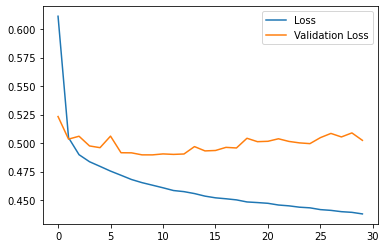

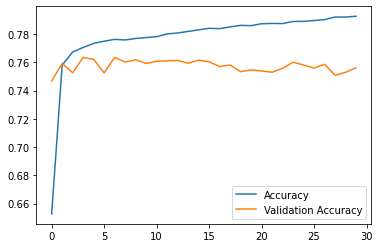

In [12]:
plots(model)

In [13]:
#checking with fake reviews

fake_reviews = ["This is good", 
                "This is bad",
                "Can do better",
                "Not as nice as I thought",
                "I am Batman",
                "What do you think of ban?"]

In [14]:
def predict_review(model, review, padding="post", trunc="post", max_len=100):
    review_seq = tokenizer.texts_to_sequences(review)
    review_pad = pad_sequences(review_seq, maxlen=max_len, padding=padding, truncating=trunc)
    prediction = model.predict(review_pad)
    for i in range(len(review)):
        print(review[i], prediction[i])

In [15]:
predict_review(model, fake_reviews, padding, trunc, max_len)

This is good [0.8705378]
This is bad [0.1364142]
Can do better [0.87442714]
Not as nice as I thought [0.5259521]
I am Batman [0.53745836]
What do you think of ban? [0.8367961]
